In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [2]:
# Define the date range and ticker
start_date = '2010-01-01'
end_date = '2024-05-13'
ticker = 'EURUSD=X'  # Yahoo Finance ticker for EUR/USD exchange rate

In [3]:
# Download the EUR/USD exchange rate data
data = yf.download(ticker, start=start_date, end=end_date)
data.head(2)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0


In [4]:
# Remove missing values
data.dropna(inplace=True)


In [5]:
# Calculate daily returns of EUR/USD exchange rate
data['Return'] = data['Close'].pct_change()

In [6]:
# Remove the first row with NaN return
data.dropna(subset=['Return'], inplace=True)


In [7]:
# Fetch Federal Reserve interest rate data
fed_data = yf.download("^IRX", start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [8]:
fed_data.dropna(inplace=True)
fed_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.080,0.080,0.055,0.055,0.055,0
2010-01-05,0.060,0.065,0.040,0.060,0.060,0
2010-01-06,0.060,0.060,0.045,0.045,0.045,0
2010-01-07,0.045,0.055,0.040,0.045,0.045,0
2010-01-08,0.045,0.045,0.035,0.040,0.040,0
...,...,...,...,...,...,...
2024-05-06,5.238,5.243,5.235,5.240,5.240,0
2024-05-07,5.240,5.243,5.240,5.243,5.243,0
2024-05-08,5.245,5.245,5.245,5.245,5.245,0


In [9]:
# Merge EUR/USD data with Federal Reserve data
new_data = data.merge(fed_data['Adj Close'], how='left', left_index=True, right_index=True)
new_data.rename(columns={'Adj Close_y': 'Fed Rate'}, inplace=True)


In [10]:
# Remove missing values again
new_data.dropna(inplace=True)


In [11]:
# Check column names before dropping columns
print(new_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Return',
       'Fed Rate'],
      dtype='object')


In [12]:
# Drop the columns not used for modeling
# Ensure only the intended columns are dropped
columns_to_drop = ['Adj Close', 'Close'] if 'Adj Close' in new_data.columns else ['Close']
new_data.drop(columns_to_drop, axis=1, inplace=True)


In [13]:
# Check the dataframe after dropping columns
new_data.head()

,Open,High,Low,Adj Close_x,Volume,Return,Fed Rate
Date,,,,,,,
2010-01-04,1.431004,1.445191,1.426208,1.442398,0,0.002366,0.055
2010-01-05,1.442710,1.448310,1.435194,1.436596,0,-0.004022,0.060
2010-01-06,1.436596,1.443460,1.429123,1.440403,0,0.002650,0.045
2010-01-07,1.440300,1.444481,1.430206,1.431803,0,-0.005971,0.045
2010-01-08,1.432090,1.443606,1.427104,1.441109,0,0.006499,0.040


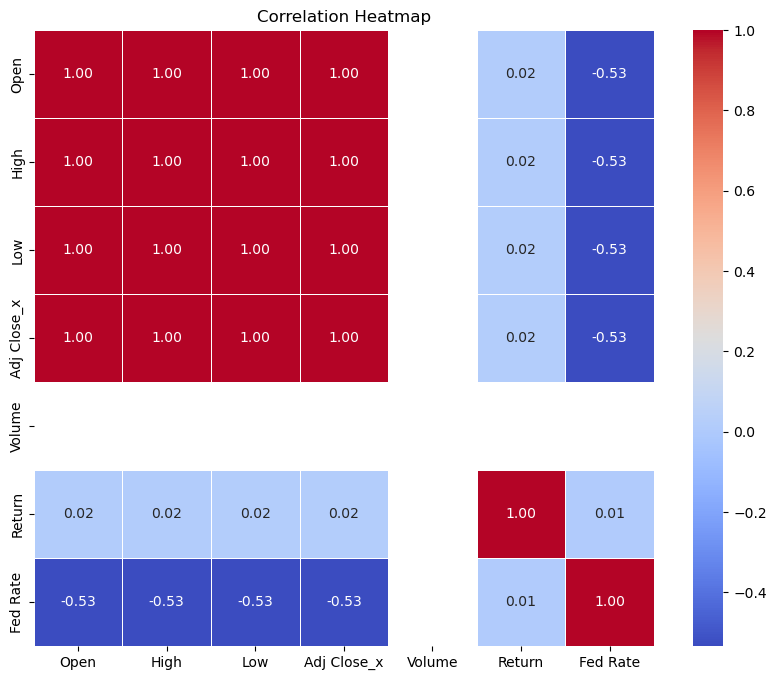

In [14]:
# Calculate the correlation matrix
corr = new_data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
new_data['Volume'].sum()

0

In [16]:
# Prepare data for LSTM model
features = new_data.drop(columns=['Return', 'Volume'])
target = new_data['Return']

In [17]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [18]:
# Create sequences for LSTM
def create_sequences(data, target, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(target[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(features_scaled, target.values, seq_length)

In [19]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

c:\Users\user\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0018 - val_loss: 3.6293e-05
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.3868e-04 - val_loss: 3.0644e-05
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6161e-04 - val_loss: 1.8861e-05
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0455e-04 - val_loss: 1.7168e-05
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.5514e-05 - val_loss: 1.6131e-05
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.2927e-05 - val_loss: 1.5518e-05
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.8263e-05 - val_loss: 1.6654e-05
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6748e-05 - val_loss: 1.7424e-05
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.8946e-05 - val_loss: 1.7498e-05
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.6414e-05 - val_loss: 1.8752e-05
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9961e-05 -

In [22]:
# Predict on the test set
y_pred = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test R2 Score: {r2}")

Test MSE: 2.372188434780826e-05
Test R2 Score: 0.035069026899517186


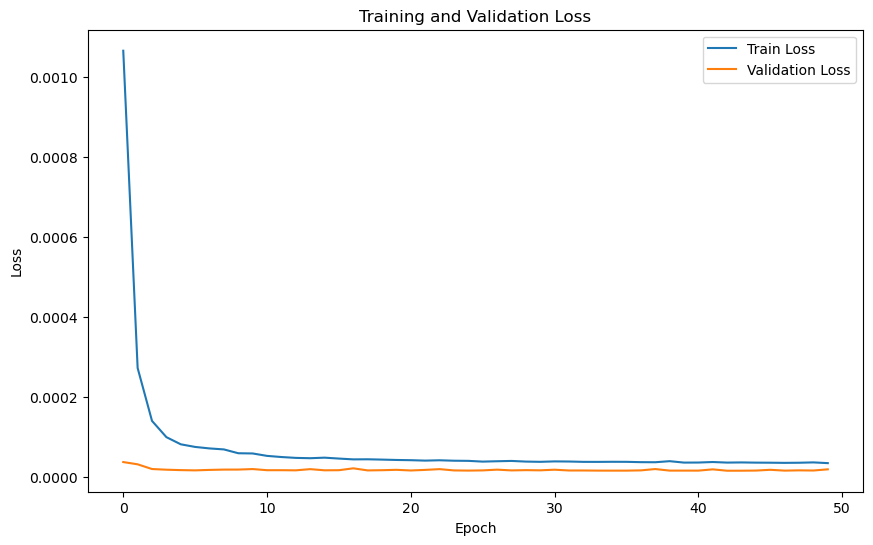

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()